In [1]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

Using TensorFlow backend.


In [2]:
from gensim.utils import lemmatize
from nltk.corpus import stopwords

#### LDA Training

In [3]:
def build_texts(fname):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    with open(fname) as f:
        for line in f:
            yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

In [4]:
stops = set(stopwords.words('english'))  # nltk stopwords list

In [5]:
def process_texts(texts):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    # 2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = [[word for word in line if word not in stops] for line in texts]
    # texts = [bigram[line] for line in texts]
    texts = [[word.split('/')[0] for word in lemmatize(' '.join(line), 
                    allowed_tags=re.compile('(NN)'), min_length=3)] for line in texts]
    return texts

In [6]:
train_texts = list(build_texts('consolidated.txt'))

In [7]:
train_texts = process_texts(train_texts)

In [8]:
len(train_texts)

1941

In [9]:
train_texts_sklearn = [" ".join(ls) for ls in train_texts]

### Sklearn

In [10]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = stops,
                                lowercase = True,
                                max_df = 0.5, 
                                min_df = 0.05,
                                ngram_range = (1, 4))
dtm_tf = tf_vectorizer.fit_transform(train_texts_sklearn)
print(dtm_tf.shape)

(1941, 643)


In [11]:
vocabulary_gensim = {}
vocab = Dictionary()
for key, val in tf_vectorizer.vocabulary_.items():
    vocabulary_gensim[val] = key
_ = vocab.merge_with(vocabulary_gensim)   
corpus_vect_gensim = gensim.matutils.Sparse2Corpus(dtm_tf, documents_columns=False)

In [12]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

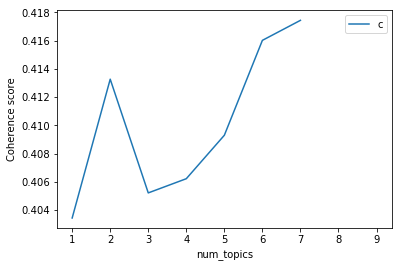

In [13]:
lmlist, c_v = evaluate_graph(dictionary=vocab, corpus=corpus_vect_gensim, texts=train_texts, limit=10)

In [22]:
ldamodel = LdaModel(corpus=corpus_vect_gensim, num_topics=20, id2word=vocab)

In [23]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [24]:
pyLDAvis.gensim.prepare(ldamodel, corpus_vect_gensim, vocab)

/home/hadrian/anaconda3/envs/py27/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
10     17.387755        1       1 -0.039347  0.017761
6       8.707326        1       2  0.033213  0.023274
5       8.642268        1       3 -0.004461 -0.030229
16      6.339150        1       4 -0.025090  0.008810
13      5.796501        1       5  0.043832  0.008109
3       5.564299        1       6 -0.001576 -0.019251
0       5.164252        1       7 -0.018132  0.002100
14      5.102110        1       8 -0.004909 -0.013654
15      4.613895        1       9  0.032873 -0.005484
19      4.477819        1      10 -0.012165  0.008884
17      4.432031        1      11  0.006592  0.001178
4       3.627730        1      12  0.007465 -0.005362
1       3.458621        1      13  0.005214  0.004770
11      3.055774        1      14 -0.002712 -0.001114
18      2.732283        1      15 -0.003520  0.020208
2       2.672697        1      16 -0.017358 -0.009741
9       2.205754        1      17 -0.005181  0.018851
12      2.143627        1      18  0.007229 -0.024234
8       1.996307        1      19  0.001749  0.008568
7       1.879802        1      20 -0.003716 -0.013445, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
444   Default  5186.000000              drug  5186.000000  30.0000  30.0000
141   Default  2376.000000             blood  2376.000000  29.0000  29.0000
136   Default  2672.000000           product  2672.000000  28.0000  28.0000
564   Default  5635.000000          facility  5635.000000  27.0000  27.0000
14    Default  5229.000000           program  5229.000000  26.0000  26.0000
208   Default  2154.000000          medicine  2154.000000  25.0000  25.0000
248   Default  3603.000000            system  3603.000000  24.0000  24.0000
196   Default  2224.000000        laboratory  2224.000000  23.0000  23.0000
538   Default  2693.000000           patient  2693.000000  22.0000  22.0000
306   Default  5749.000000               doh  5749.000000  21.0000  21.0000
250   Default  2687.000000        regulation  2687.000000  20.0000  20.0000
175   Default  1773.000000              food  1773.000000  19.0000  19.0000
373   Default  2038.000000           project  2038.000000  18.0000  18.0000
265   Default  3200.000000            center  3200.000000  17.0000  17.0000
532   Default  3152.000000              unit  3152.000000  16.0000  16.0000
220   Default  3024.000000              care  3024.000000  15.0000  15.0000
222   Default  2949.000000          training  2949.000000  14.0000  14.0000
637   Default  2219.000000              rule  2219.000000  13.0000  13.0000
214   Default  2201.000000          standard  2201.000000  12.0000  12.0000
364   Default  2197.000000       requirement  2197.000000  11.0000  11.0000
4     Default  1523.000000             child  1523.000000  10.0000  10.0000
171   Default  2761.000000            policy  2761.000000   9.0000   9.0000
340   Default  1259.000000          employee  1259.000000   8.0000   8.0000
360   Default  2719.000000          activity  2719.000000   7.0000   7.0000
270   Default   910.000000               bed   910.000000   6.0000   6.0000
180   Default  2383.000000         provision  2383.000000   5.0000   5.0000
460   Default  2726.000000       development  2726.000000   4.0000   4.0000
621   Default  2495.000000        department  2495.000000   3.0000   3.0000
63    Default   916.000000             water   916.000000   2.0000   2.0000
285   Default  2424.000000            agency  2424.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
379   Topic20    11.853313             label   283.289522   0.8001  -6.4444
364   Topic20    91.348204       requirement  2197.968210   0.7934  -4.4024
606   Topic20    11.747405  health insurance   283.308427   0.7911  -6.4534
315   Topic20    69.319232       

In [25]:
ldamodel.save('consolidated_lda.bin')
vocab.save('consolidated_corpus.dict')

#### Productionization

In [4]:
import pandas as pd
themes = ['mnchn', 'spec_pop', 'geriatric', 'adolescent']
keywords = {
    theme: pd.read_excel('data/Thesaurus Initial List.xlsx', sheetname=theme, usecols=['AO', 'Keywords'], dtype=
                         {'Keywords': str}).fillna(method='ffill') for theme in themes
}
keywords_final = {}
for theme in themes:
    keywords[theme].Keywords += ','
    keywords_final[theme] = keywords[theme].groupby('AO').sum()['Keywords'].str.replace(
        '"', '').str.replace('“', '').str.replace('&', ' ').str.replace(',', ' ').str.replace('/', '').reset_index()
    

In [5]:
lda_model = gensim.models.LdaModel.load('consolidated_lda.bin')

In [6]:
id2word = gensim.corpora.Dictionary.load('consolidated_corpus.dict')

In [7]:
for key in keywords_final.keys():
    keywords_final[key]['LDA'] = ''
    for i, r in keywords_final[key].iterrows():
        query = r['Keywords'].split()
        results = sorted(lda_model[id2word.doc2bow(query)], key=lambda tup: tup[1], reverse=True)
        r['LDA'] = ' '.join([i[0] for i in lda_model.show_topic(results[0][0], topn=20)])

In [8]:
for key in keywords_final.keys():
    keywords_final[key].to_csv(key+'.csv', index=False)